In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

np.random.seed(333)

# Gibbs sampling with refractory period

In [2]:
images = np.load('images_zca_norm.npy')
PFs = np.load('pfs.npy')

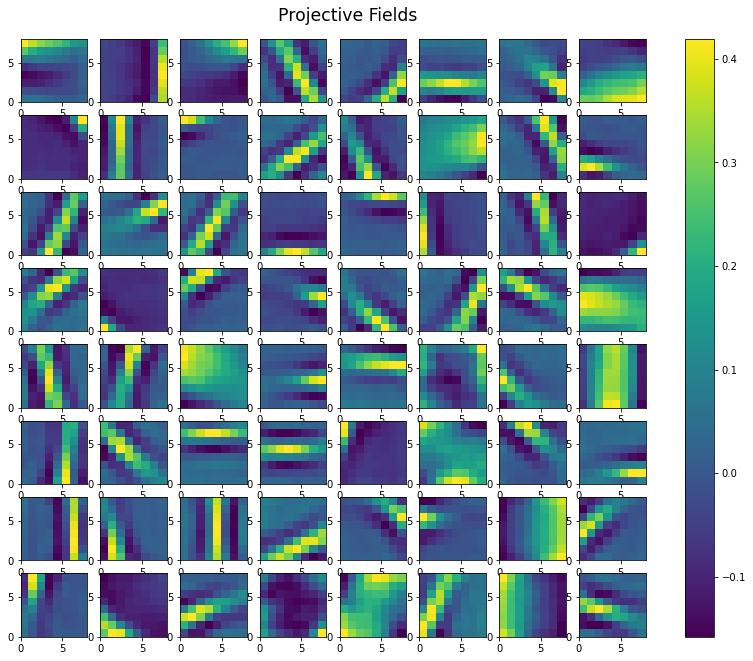

In [3]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(14, 11))

for i in range(8):
    for j in range(8):
        order = i*8 +j                             # neuron number
        ax = axes[i][j].pcolormesh(PFs[order])
        
fig.colorbar(ax, ax=axes[:, :], location='right')

fig.suptitle('Projective Fields', x = 0.45, y = 0.92, size = 'xx-large')

#fig.tight_layout(pad=3.0)
plt.show()

In [24]:
z_initial = np.random.binomial(1, 0.01, 64)     # Draw initial z vector from a Gaussian dist.
                                                # Here we used small probability to shorten the burn-in time
Pf = np.transpose(PFs.reshape(64,64))           # Define weight matrix such as
                                                # every column corresponds to PF of the corresponding neuron
W = np.matmul(np.transpose(Pf[:,:]),Pf[:,:])    # Generate weight matrix 
Time = 0.4 #sec
delta_T = 0.001 #sec
N_sampling = Time/delta_T                       # Sampling count = 400

In [34]:
def post_synaptic_potential(Image, i, z):
    weight_i = W
    weight_i[i] = 0                                                    # w_ii = 0
    time_course = np.matmul(np.transpose(weight_i),z)                  # how other neurons contribute PSP now
    bias = np.matmul(np.transpose(Pf[:,i]),Image.reshape(64,1))        # regulation of own excitability
    return bias + time_course

In [ ]:
def Gibbs_sampling(I, n_sampling):
    response_matrix = np.zeros([64,n_sampling])  # Initiate sampling matrix
    response_matrix[:,0] = z_initial             # Set z_initial as the first column
    
    for i in range(1, n_sampling):               # Start from the second column, and iterate through time
        response_matrix[:,i] = response_matrix[:,i-1]
        for j in range(64):                      # Iterate through neourons
            posterior_ij = posterior_ij_1(I, response_matrix[:,i], j)
            response_matrix[j][i] = np.random.binomial(1, posterior_ij)
   
    return response_matrix

In [7]:
a = [np.matmul(np.transpose(W[:,63]),W[:,i]) for i in range(64)]
np.shape(a)

(64,)

In [8]:
a = np.matmul(np.transpose(W[:,:]),W[:,63])
np.shape(a)

(64,)

In [ ]:
3 == 3

In [12]:
np.matmul(np.transpose(W[:,:]),W[:,1]) == np.matmul(np.transpose(W[:,:]),W[:,:])[:,1]

array([False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False,  True, False,  True,  True,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True])

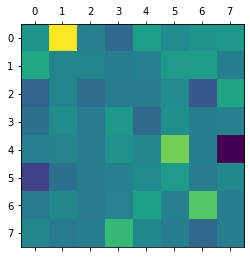

In [44]:
a = np.matmul(np.transpose(Pf[:,:]),Pf[:,:])
#a[1,1] = 0
plt.matshow(np.reshape(W[1], (8,8)))

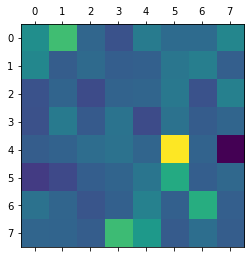

In [40]:
plt.matshow(np.reshape(np.matmul(np.transpose(W[:,:]),W[:,1]), (8,8)))